In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib
import circle_fit as cf
from scipy.optimize import minimize

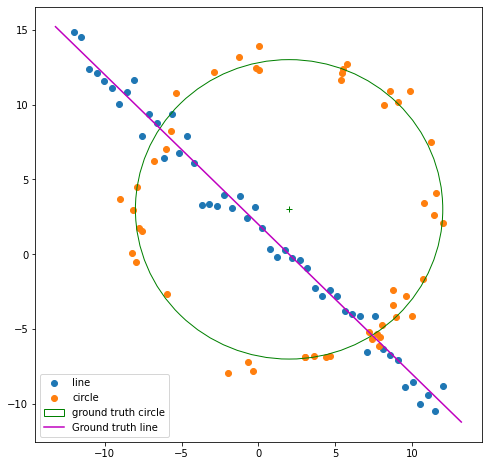

In [2]:
N = 100
half_n = N//2
r = 10
x0_gt,y0_gt=2,3 # Center
s = r/16
t = np.random.uniform(0 , 2*np.pi , half_n )
n = s*np.random.randn(half_n)
x,y=x0_gt +( r + n)*np.cos( t ),y0_gt + ( r + n)*np.sin( t )
X_circ = np.hstack((x.reshape ( half_n , 1 ) , y.reshape( half_n , 1 )))
s = 1.
m,b =-1,2
x =np.linspace(-12, 12 , half_n )
y = m*x + b + s*np.random.randn( half_n )
X_line = np.hstack((x.reshape(half_n, 1 ) , y.reshape( half_n ,1)))
X = np.vstack((X_circ,X_line))

fig,ax =plt.subplots(1,1, figsize=(8,8))
ax.scatter(X_line [:,0],X_line[:,1],label= "line")
ax.scatter( X_circ[:,0],X_circ[:,1],label= "circle")
circle_gt = plt.Circle((x0_gt , y0_gt ) , r , color= "g" , fill=False , label= "ground truth circle" )
ax.add_patch( circle_gt )
ax.plot((x0_gt ),(y0_gt),"+",color="g")
x_min,x_max = ax.get_xlim( )
x_ = np.array([ x_min , x_max ])
y_ = m*x_ + b
plt.plot( x_ , y_ , color= "m" , label=  "Ground truth line" )
plt.legend ( )

Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.108673193975906e-10
            Iterations: 6
            Function evaluations: 29
            Gradient evaluations: 6
rex.x:  [0.71051526 0.70368179 1.45973443]
Iteration =  0 . No. inliners =  58
Optimization terminated successfully    (Exit mode 0)
            Current function value: 22.714855041511765
            Iterations: 5
            Function evaluations: 26
            Gradient evaluations: 5
[0.70939167 0.70481449 1.30166158] 22.714855041511765
A better model found ...  [0.70939167 0.70481449 1.30166158] 22.714855041511765
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.5329228559049234e-08
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6
rex.x:  [ 0.61052017  0.79200107 -1.26172645]
Iteration =  1 . No. inliners =  24
Optimization terminated successfully    (Exit mode 0)
            Current 

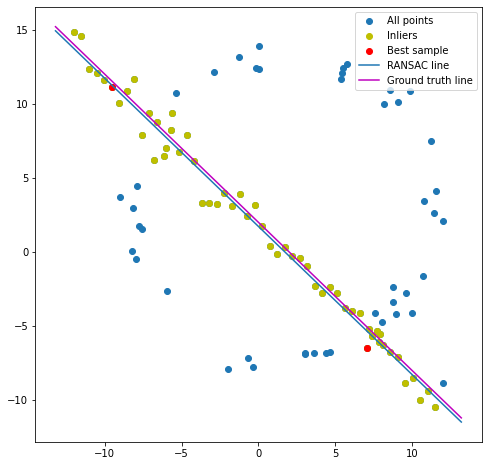

In [3]:
import math
N = X.shape[0]
X_ = X

def line_equation_from_points(x1, y1, x2, y2):
    # Calculate the direction vector (Δx, Δy)
    delta_x = x2 - x1
    delta_y = y2 - y1

    # Calculate the normalized vector (a, b)
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude

    # Calculate d
    d = (a * x1) + (b * y1)

    # Return the line equation in the form ax + by = d
    return a, b, d

# RANSAC to fit a line
def line_tls(x, indices):
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a*X_[indices,0] + b*X_[indices,1] - d))

# Constraint
def g(x):
    return x[0]**2 + x[1]**2 - 1

cons = ({'type': 'eq', 'fun': g})

# Computing the consensus (inliers)
def consensus_line(X, x, t):
    a, b, d = x[0], x[1], x[2]
    error = np.absolute(a*X_[:,0] + b*X_[:,1] - d)
    return error < t

t = 1.8  # Threshold value to determine data points that are fit well by model.
d = 0.4*N   # Number of close data points required to assert that a model fits well to data.
s = 2       # Minimum number of data points required to estimate model parameters.

inliers_line = []        # Indinces of the inliers
max_iterations = 200
iteration = 0
best_model_line = []     # Best model normal (a, b) and distance from origin d
best_error = np.inf
best_sample_line = []    # Three-point sample leading to the best model computation
res_only_with_sample = [] # Result (a, b, d) only using the best sample
best_inliers_line = []   # Inliers of the model computed form the best sample

while iteration < max_iterations:   
    indices = np.random.randint(0, N, s) # A sample of three (s) points selected at random
    x0 = np.array([1, 1, 0]) # Initial estimate
    res = minimize(fun = line_tls, args = indices, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
    inliers_line = consensus_line(X_, res.x, t) # Computing the inliers
    print('rex.x: ', res.x)    
    print('Iteration = ', iteration, '. No. inliners = ', inliers_line.sum())
    if inliers_line.sum() > d:
        x0 = res.x
        # Computing the new model using the inliers
        res = minimize(fun = line_tls, args = inliers_line, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
        print(res.x, res.fun)
        if res.fun < best_error:
            print('A better model found ... ', res.x, res.fun)
            best_model_line = res.x
            best_eror = res.fun
            best_sample_line = X_[indices,:]
            res_only_with_sample = x0
            best_inliers_line = inliers_line

    iteration += 1

print('Best line model', best_model_line)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X_[:,0],X_[:,1], label='All points')
ax.scatter(X_[best_inliers_line,0],X_[best_inliers_line,1], color='y', label='Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='r', label='Best sample')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()

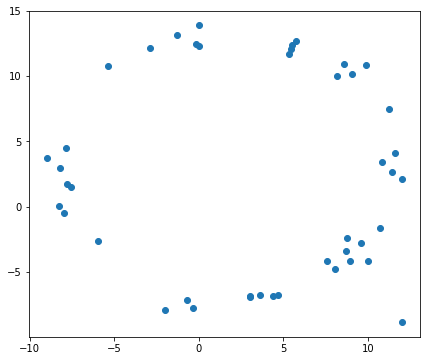

In [4]:
outliers=best_inliers_line ^ True
fig,ax=plt.subplots(1,1,figsize=(7,6))
ax.scatter(X[outliers,0],X[outliers,1])


rex.x:  [1.22891061 1.50343325 9.42682865]
Iteration =  0 . No. inliners =  38
2.8687814100417616e-07
[1.57911429 2.82177837 9.98853596] 10.109057488501858
A better model found ...  [1.57911429 2.82177837 9.98853596] 10.109057488501858
rex.x:  [ 1.06067297  4.10939016 11.12705673]
Iteration =  1 . No. inliners =  40
4.1635177791358923e-07
[ 1.61793354  3.12937048 10.16598036] 12.612116815484859
A better model found ...  [ 1.61793354  3.12937048 10.16598036] 12.612116815484859
rex.x:  [ 8.15422894 -6.79123695 17.76794415]
Iteration =  2 . No. inliners =  14
4.969786844770543e-07
rex.x:  [ 1.57721118  2.95648668 10.22235164]
Iteration =  3 . No. inliners =  43
3.588538816355979e-09
[ 1.62800638  3.02076733 10.10405821] 14.144774126934655
A better model found ...  [ 1.62800638  3.02076733 10.10405821] 14.144774126934655
rex.x:  [ 1.76132765  3.92269772 10.70147552]
Iteration =  4 . No. inliners =  43
5.8153937219518314e-12
[ 1.62800524  3.02075823 10.10406085] 14.144774128648901
A better 

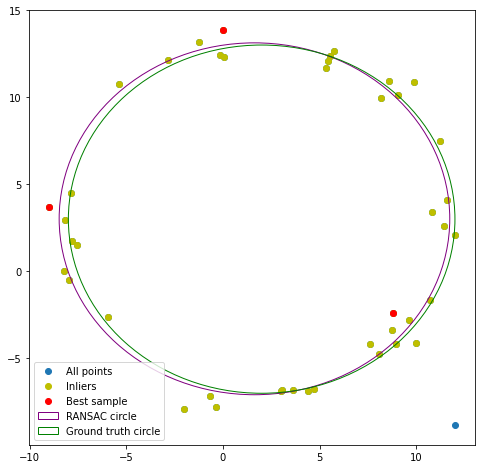

In [26]:
outliers=~(best_inliers_line)
circle_cord=X[outliers]
N=circle_cord.shape[0]

inliers_circle = []        # Indinces of the inliers
max_iterations = 200
iteration = 0
best_model_circle = []     # Best model normal (a, b) and distance from origin d
best_error = np.inf
best_sample_circle = []    # Three-point sample leading to the best model computation
res_only_with_sample = [] # Result (a, b, r) only using the best sample
best_inliers_circle = []   # Inliers of the model computed form the best sample


# RANSAC to fit a circle
def circle_tls(x, indices):
    a, b, r = x[0], x[1], x[2]
    return np.sum(np.square(np.sqrt(np.square(X_[indices,0] - a) + np.square(X_[indices,1] - b))-r))

# Computing the consensus (inliers)
def consensus_circle(X, x, t):
    a, b, r = x[0], x[1], x[2]
    error = np.absolute(np.sqrt(np.square(X_[:,0] - a) + np.square(X_[:,1] - b))-r)
    return error < t

def g(x):
    return [10 - x[0], 10 - x[1]]  # Constraints to keep x and y less than 10

# Define the constraint dictionary
cons = ({'type': 'ineq', 'fun': g})

t = 2.3   # Threshold value to determine data points that are fit well by model.
d = 0.6*N   # Number of close data points required to assert that a model fits well to data.
s = 3       # Minimum number of data points required to estimate model parameters.


while iteration < max_iterations:   
    indices = np.random.randint(0, N, s) # A sample of three (s) points selected at random
    x0 = np.array([1, 1, 1]) # Initial estimate
    res = minimize(fun = circle_tls, args = indices, constraints = cons, x0 = x0, tol= 1e-6)
    inliers_circle = consensus_circle(X_, res.x, t) # Computing the inliers
    print('rex.x: ', res.x)    
    print('Iteration = ', iteration, '. No. inliners = ',  inliers_circle.sum())
    print(circle_tls(res.x, indices))
    if inliers_circle.sum() > d:
        x0 = res.x
        # Computing the new model using the inliers
        res = minimize(fun = circle_tls, args = inliers_circle, x0 = x0, tol= 1e-6, constraints=cons)
        print(res.x, res.fun)
        if res.fun < best_error:
            print('A better model found ... ', res.x, res.fun)
            best_model_circle = res.x
            best_eror = res.fun
            best_sample_circle = X_[indices,:]
            res_only_with_sample = x0
            best_inliers_circle = inliers_circle

    iteration += 1

print('Best circle model', best_model_circle)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(circle_cord[:,0],circle_cord[:,1], label='All points')
ax.scatter(X_[best_inliers_circle,0],X_[best_inliers_circle,1], color='y', label='Inliers')
ax.scatter(best_sample_circle[:,0],best_sample_circle[:,1], color='r', label='Best sample')
circle_gt = plt.Circle( ( best_model_circle[0] , best_model_circle[1] ) , best_model_circle[2] , color= 'purple' , fill =False , label=  'RANSAC circle' )
ax.add_patch(circle_gt)
circle_gt = plt.Circle( ( x0_gt , y0_gt ) , r , color= 'g' , fill =False , label=  'Ground truth circle' )
ax.add_patch(circle_gt)
plt.legend()


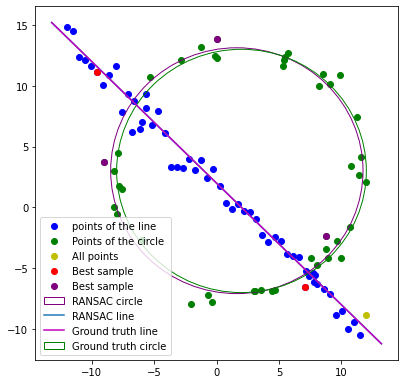

In [28]:
remain=~(best_inliers_circle)

fig, ax = plt.subplots(1, 1, figsize=(6.5,6.5))
ax.scatter(X[best_inliers_line,0], X[best_inliers_line,1], color="b",label="points of the line")
ax.scatter(circle_cord[best_inliers_circle,0], circle_cord[best_inliers_circle,1], color="g", label="Points of the circle")
ax.scatter(circle_cord[remain,0], circle_cord[remain,1], color="y", label="All points")
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='r', label='Best sample')
ax.scatter(best_sample_circle[:,0],best_sample_circle[:,1], color='purple', label='Best sample')
circle_gt = plt.Circle( ( best_model_circle[0] , best_model_circle[1] ) , best_model_circle[2] , color= 'purple' , fill =False , label=  'RANSAC circle' )
ax.add_patch(circle_gt)
plt.plot(x_, y_,  label='RANSAC line')
plt.plot(x_, y_, color='m', label='Ground truth line')
circle_gt = plt.Circle( ( x0_gt , y0_gt ) , r , color= 'g' , fill =False , label=  'Ground truth circle' )
ax.add_patch(circle_gt)
plt.legend()
